# Analysis of Yelp Business Intelligience Data

This notebook contains an analysis of Yelp's business, review, and user data.
This dataset comes from https://www.kaggle.com/yelp-dataset/yelp-dataset.

This data has been stored in a public S3 bucket 's3://yelp-reviews/data/'

## Installation and Initial Setup

External Packages downloaded : pandas, matplotplib, and seaborn

In [1]:
sc.install_pypi_package("pandas==1.0.3")
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("seaborn==0.10.1")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1588557186318_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Importing

Necessary packages are imported

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pyspark.sql.functions as F
from pyspark.sql.types import *

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Loading Data

The Yelp business dataset is loaded into a spark dataframe

In [3]:
df_business = spark.read.format('json').options(header='true',inferSchema = True).load(
    's3://yelp-reviews/data/*business.json')                             
                                                                                     

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Overview of Data

Display the number of rows and columns in the business dataset

In [4]:
print(f'Columns:{len(df_business.columns)} | Rows: {df_business.count()}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Columns:14 | Rows: 209393

Display the DataFrame schema below

In [5]:
df_business.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

Display of the first 5 rows with the following columns:
- business_id
- name
- city
- state
- stars
- categories   

In [6]:
cols = ['business_id','name','city','state','stars','categories']
df_business.select(cols).show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+---------------+-----+-----+--------------------+
|         business_id|                name|           city|state|stars|          categories|
+--------------------+--------------------+---------------+-----+-----+--------------------+
|f9NumwFMBDn751xgF...|The Range At Lake...|      Cornelius|   NC|  3.5|Active Life, Gun/...|
|Yzvjg0SayhoZgCljU...|   Carlos Santo, NMD|     Scottsdale|   AZ|  5.0|Health & Medical,...|
|XNoUzKckATkOD1hP6...|             Felinus|       Montreal|   QC|  5.0|Pets, Pet Service...|
|6OAZjbxqM5ol29BuH...|Nevada House of Hose|North Las Vegas|   NV|  2.5|Hardware Stores, ...|
|51M2Kk903DFYI6gnB...|USE MY GUY SERVIC...|           Mesa|   AZ|  4.5|Home Services, Pl...|
+--------------------+--------------------+---------------+-----+-----+--------------------+
only showing top 5 rows

# Analyzing Categories
#### How many unique categories are represented in this dataset?

Currently categories are alllocated to each business as a list. 

In order to answer questions about the categories, this list should be broken down into seperate row, where one row has one category per business. 

### Association table
Break out table of categories is made. 

This table is an association table mapping a single business_id multiple times to each distinct category it falls under. 

In [7]:
break_cols =['business_id','categories']
business_cat = df_business.select(break_cols).withColumn('category',F.explode(F.split('categories',', '))).select([
    'business_id','category'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Display of the first 5 rows of the association table

In [8]:
business_cat.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------------+
|         business_id|        category|
+--------------------+----------------+
|f9NumwFMBDn751xgF...|     Active Life|
|f9NumwFMBDn751xgF...|Gun/Rifle Ranges|
|f9NumwFMBDn751xgF...|     Guns & Ammo|
|f9NumwFMBDn751xgF...|        Shopping|
|Yzvjg0SayhoZgCljU...|Health & Medical|
+--------------------+----------------+
only showing top 5 rows

### Total Unique Categories

What is the total number of unique categories available?

In [9]:
business_cat.select('category').distinct().count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1336

### Total Categories By Business

Create table containing counts of businesses that fall under each category.

### Counts of Businesses / Category

In [10]:
cat_counts=business_cat.groupby('category').count()
cat_counts.show(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-----+
|           category|count|
+-------------------+-----+
|     Paddleboarding|   36|
|     Dermatologists|  341|
|   Historical Tours|   54|
|   Hot Air Balloons|   21|
|Mobile Home Dealers|   16|
|      Data Recovery|  195|
|      Videographers|  169|
|      Skating Rinks|  104|
|             Fondue|   54|
|    Pet Photography|   49|
|  Pet Waste Removal|   34|
|        Boat Repair|  100|
|            Beaches|   74|
|       Contract Law|   13|
|       Aerial Tours|   28|
|  Signature Cuisine|    1|
|        Hobby Shops|  828|
|           Day Spas| 2880|
|              Reiki|  312|
|           Honduran|    8|
+-------------------+-----+
only showing top 20 rows

### Bar Chart of Top Categories

Bar chart is created to graphically display the top 20 categories. 

In [11]:
top_cats = cat_counts.orderBy('count',ascending=False).toPandas().iloc[0:20,]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(x="count",y="category",
            orient="h",data=top_cats,color='skyblue',ax=ax).set_title('Top Categories by Business');
plt.tight_layout()
plt.box(False) 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

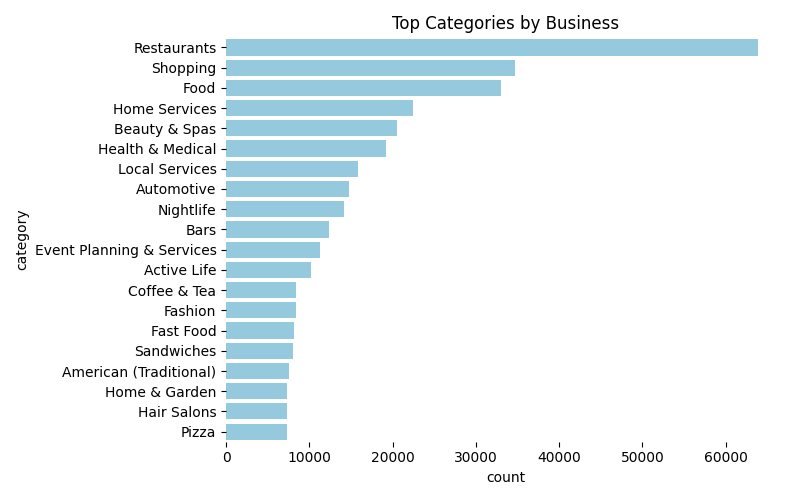

In [13]:
%matplot plt

# Do Yelp Reviews Skew Negative?

Often times it is said that only people who write a written review are those that are extremely dissatisfied or satisfied with the service they received.

How true is this really?

## Loading user review dataset into a spark dataframe

The user review data is loaded from S3 into a Spark dataframe

In [14]:
df_review = spark.read.format('json').options(header='true',inferSchema = True).load(
    's3://yelp-reviews/data/*review.json')

df_review.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

Display the first five rows of the reviews dataframe, with business_id and stars as the selected columns

In [15]:
df_review.select('business_id','stars').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|         business_id|stars|
+--------------------+-----+
|-MhfebM0QIsKt87iD...|  2.0|
|lbrU8StCq3yDfr-QM...|  1.0|
|HQl28KMwrEKHqhFrr...|  5.0|
|5JxlZaqCnk1MnbgRi...|  1.0|
|IS4cv902ykd8wj1TR...|  4.0|
+--------------------+-----+
only showing top 5 rows

The reviews dataset is then aggregated along the stars column to compute the average stars per business as accumulated by users who took the time to submit a written review. 

In order to determine written review, a where condition for "text" is not null is added. A condition of length(text)>1 is also added to further make sure that the only data selected is for reviews that have a written component.

In [16]:
df_avgstars = df_review.select('business_id','stars').where("text is not null AND length(text)>1").groupby('business_id').avg()
df_avgstars.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+
|         business_id|        avg(stars)|
+--------------------+------------------+
|ATeOjZzE3VOI-RW7F...| 3.433734939759036|
|RMjCnixEY5i12Ciqn...|3.5316455696202533|
|vbUABNAQI2iwN7v0x...|2.4545454545454546|
|VHsNB3pdGVcRgs6C3...| 3.411764705882353|
|r-W1HPIZ3V6S2DaXh...| 4.852459016393443|
+--------------------+------------------+
only showing top 5 rows

This resultant aggregate dataframe is then merged with the original business dataframe that was made earlier, in order to compare the average yelp user rating of a business to the business's actual rating. 

In [17]:
business_ratings= df_avgstars.join(df_business,on=['business_id'],how='inner')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Display for the first few rows of this resultant dataframe.

Note, that ordering by avg(stars) will result in a different order each time, as multiple business have the same rating. In an attempt to maintain a consistent order in every run of this notebook, the dataframe was ordered by 'avg(stars)' and 'name'.

Please note: When sorting by names (ascending =False), accent marked letters are ranked higher. 

In [18]:
business_ratings.select('avg(stars)','stars','name','city','state').orderBy(['avg(stars)','name'], ascending=False).show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----+--------------------+--------+-----+
|avg(stars)|stars|                name|    city|state|
+----------+-----+--------------------+--------+-----+
|       5.0|  5.0|Ûr Market & Eden'...| Phoenix|   AZ|
|       5.0|  5.0|       Épices de Cru|Montréal|   QC|
|       5.0|  5.0|   Émile Bicyclettes|Montréal|   QC|
|       5.0|  5.0|    Élisabeth & Beau| Vaughan|   ON|
|       5.0|  5.0|          À la Carte|Montréal|   QC|
+----------+-----+--------------------+--------+-----+
only showing top 5 rows

A new dataframe is created from the previously joined dataframe that contains a column called "skew".

"skew" is defined as:

*(row['avg(stars)'] - row['stars']) / row['stars']*

If the skew is negative, than we can interpret that the reviewers that left a written response were more dissatisfied than normal. If skew is positive, it can be interpreted that reviewers who left a written response were more satisfied than normal.

In [19]:
df_skew = business_ratings.withColumn('skew',(business_ratings['avg(stars)']
                                      -business_ratings['stars'])/business_ratings['stars'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The histogram below shows the distribution of "skew" in our dataframe

In [20]:
plt.clf()
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(a=df_skew.toPandas()['skew'],hist=True,color='skyblue',ax=ax)
plt.title('Top Categories by Business')
plt.box(False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

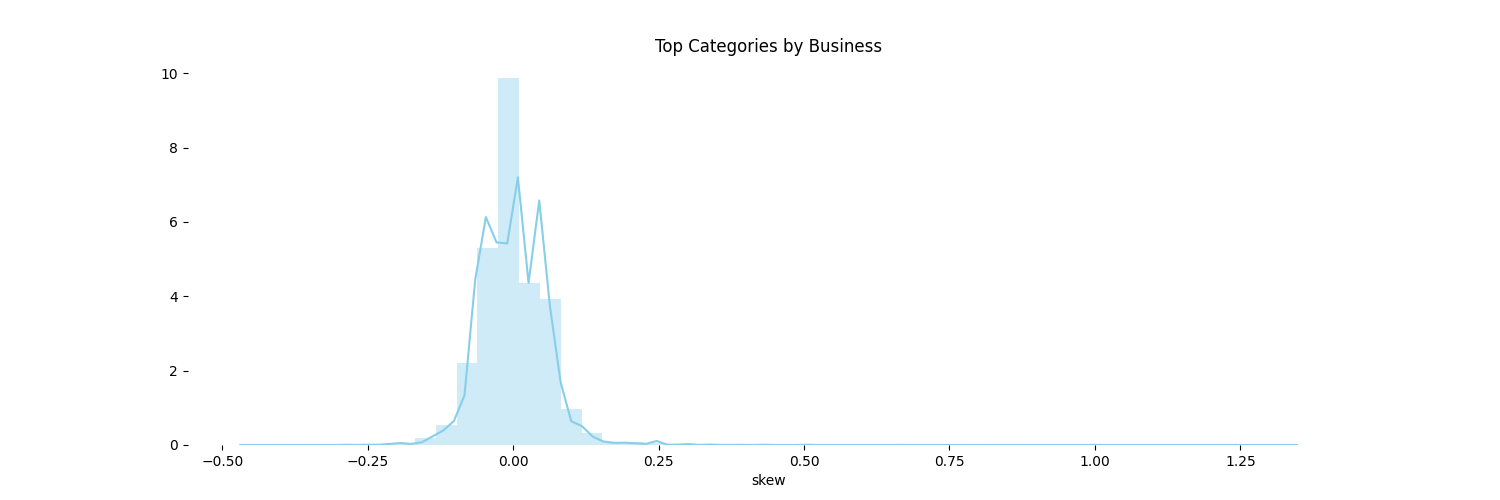

In [21]:
%matplot plt

Based on the above histogram, it can be seen that the skew of the average user rating for a business tends to center around zero, indicating that there is not much difference between the average user reported star rating and the star rating of the business in our sample. This shows that user written reviews are on average not skewed. In addition, the majority of the skewness is within the range (-.25,.25), which further indicates that on average yelp user ratings are close to the actual rating.

It is also worth noting, that when purely looking at the histogram, the 'skew' seems leptokurtic, indicating that the majority of the data centers around the mean. However, leptokurtic distributions are more susceptible to outliers. This is not suprising in yelp review data, as specific experiences can cause reviewers to give less than or greater than common ratings for a specific business. 

This graph supports the conclusion that on average, yelp user ratings of those that have took the time to write a written review tend not to be skewed, and actually are close to the actual rating of a business. 

## Part 4: Should the Elite be trusted?

How accurate or close are the ratings of an "elite" user vs the actual business rating?

### Load the user dataset
The user dataset is loaded from S3 into a spark dataframe.

In [22]:
df_user = spark.read.format('json').options(header='true',inferSchema = True).load(
    's3://yelp-reviews/data/*user.json')

df_user.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)

When merging the user dataframe with the reviews dataframe, there exists an issue of overlapping column names. 
In order to deal with that issue, certain overlapped columns are renamed, so that they can be distinguished in the newly merged dataframe. 

In [23]:
#Renaming overlapped column names between user dataset and reviews
df_user=df_user.withColumnRenamed("cool","cool_user")
df_user=df_user.withColumnRenamed("funny","funny_user")
df_user=df_user.withColumnRenamed("useful","useful_user")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Merge user dataset with reviews dataset

In [24]:
df_userreview = df_user.join(df_review, on ="user_id",how="inner")

#Renaming overlapped column names between user dataset and business
df_userreview= df_userreview.withColumnRenamed("stars","user_star")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Determine elite status of each review

In order to investigate the elite users, the elite column must be processed. Currently, the elite column displays a string in the form "year1,year2..." (e.g. "2016,2017"). This represents the years a certain user was an elite user.

In order to see if a rating came from an elite user, the year that the review was written must be in a year that the user was an elite user. 

In order to determine this, the elite column was converted into an array of ints. The year value from the date column was extracted, and a new boolean column was created, which will tell if the review was from a elite user.

It is also worth noting, that many users were never an elite user, therefore casting to type array<int> resulted in an empty array. 
    
When checking if the year from the date column was in an empty array this returned a null. In order to correct this, all nulls were then filled with the correct value of false. 

In [25]:
#Elite column shows years that user was elite.
#Creating new column to show if user was elite at time of writing review

#First step is to turn elite column of strings to a column of array<int> (array of years)
#This however creates an empty array for users that were never elite at any year.
df_userreview=df_userreview.withColumn('elite2',F.split("elite",",").cast("array<int>"))

#Extract year from date
df_userreview=df_userreview.withColumn('year',F.year('date'))

#If the year the review was written is in the array of years the user was elite, return true. Else False
#Note,if the user was never elite, comparison with an empty array will return null, this will be filled afterwards.
df_userreview= df_userreview.withColumn('elite_yn',F.arrays_overlap(df_userreview.elite2,
                                                                    F.array(df_userreview.year)))

#Comparison with empty array, when user is never a elite at any year, returns null.
#So it should be filled with False, since that user was not elite
df_userreview=df_userreview.fillna({'elite_yn':False})

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Display the first 5 rows of the merged dataframe (users and reviews) with columns:
- elite_yn
- elite
- user_star
- date

In [44]:
df_userreview.select("elite_yn","elite","user_star","date").show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+--------------------+---------+-------------------+
|elite_yn|               elite|user_star|               date|
+--------+--------------------+---------+-------------------+
|   false|                    |      4.0|2014-03-21 17:09:59|
|   false|                    |      2.0|2012-07-06 03:43:34|
|    true|2011,2012,2013,20...|      4.0|2014-09-19 01:12:10|
|   false|                    |      1.0|2014-08-28 01:31:40|
|   false|                    |      5.0|2017-05-01 16:05:57|
+--------+--------------------+---------+-------------------+
only showing top 5 rows

### Join the business ratings dataset (merge of business and ratings from above) with the newly merged user reviews dataset (merge of user and reviews dataset). 

In [27]:
df_all = df_userreview.join(business_ratings,on="business_id",how="inner")
df_all.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- business_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool_user: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny_user: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful_user: long (nullable = true)
 |-- yelping_since: string (nullable = true)
 |-- cool: l

Display the first 5 rows of our newly created dataset with columns:
- elite_yn
- user_star
- stars

In [28]:
df_all.select('elite_yn','user_star','stars').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+---------+-----+
|elite_yn|user_star|stars|
+--------+---------+-----+
|    true|      5.0|  4.0|
|   false|      5.0|  4.0|
|   false|      2.0|  4.0|
|   false|      5.0|  4.0|
|   false|      4.0|  4.0|
+--------+---------+-----+
only showing top 5 rows

Filter the dataframe for the elite user written reviews

In [29]:
df_elites= df_all.filter(df_all['elite_yn']==True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Display the percentage of elite reviews in our original dataset

In [30]:
print(f'Percentage of elite reviews in original dataset: {(df_elites.count()/df_all.count())*100}%')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Percentage of elite reviews in original dataset: 15.630818232162532%

Aggregate along the stars (actual business rating) and user_stars (user rating) that displays average stars (both actual and user rated) per business

In [31]:
df_elites_avg = df_elites.select(['business_id','stars','user_star']).groupby('business_id').avg()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Display first 5 rows of aggregation table.

In [32]:
df_elites_avg.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------+-----------------+
|         business_id|avg(stars)|   avg(user_star)|
+--------------------+----------+-----------------+
|--9e1ONYQuAa-CB_R...|       4.0|4.240641711229946|
|-6c_bJblLXUwoWfmY...|       2.5|              1.0|
|-I06hkMFrX0KBqu61...|       5.0|              5.0|
|-Qb6U1MotJfpt6OU_...|       5.0|              5.0|
|-RRnldwSqCZT6OpuW...|       5.0|              5.0|
+--------------------+----------+-----------------+
only showing top 5 rows

Create a new column "skew" that represents the skewness of an average elite user rating from the actual business rating.

skew is defined:

*(row['avg(user_star)'] - row['avg(stars)']) / row['avg(stars)']*

In [33]:
df_elites_avg=df_elites_avg.withColumn("skew",(df_elites_avg['avg(user_star)']-
                                               df_elites_avg['avg(stars)'])/df_elites_avg['avg(stars)'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Plot a histogram of "skew" column

In [34]:
plt.clf()
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(a=df_elites_avg.toPandas()['skew'],hist=True,color='skyblue',ax=ax)
plt.title('Distribution of elite skewness')
plt.box(False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

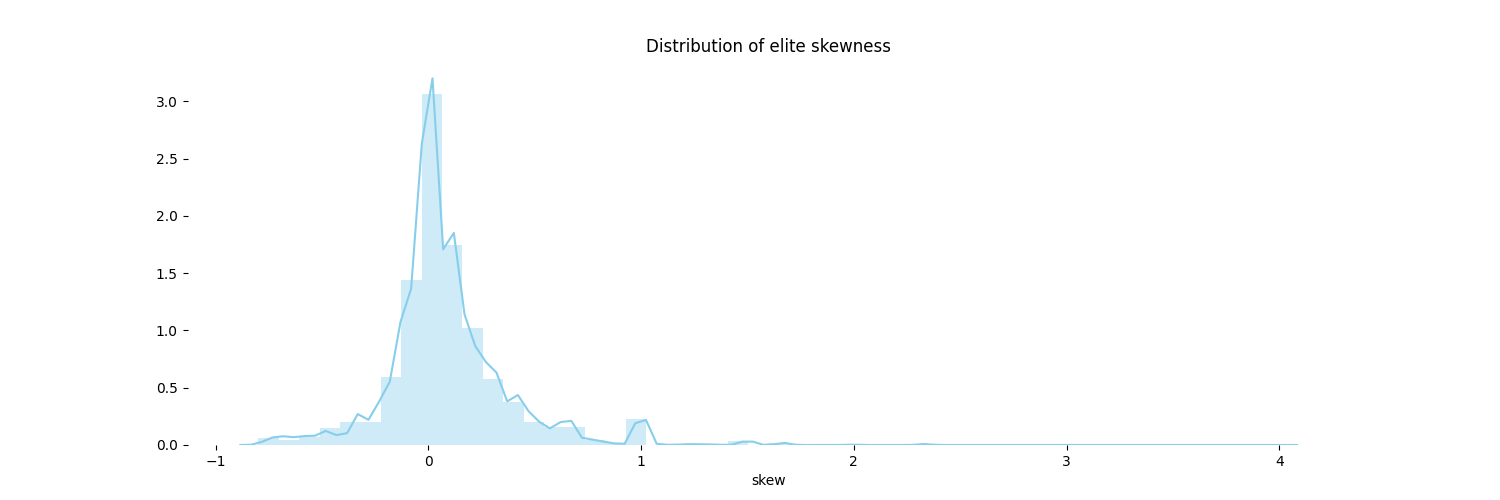

In [35]:
%matplot plt

It can be seen that the there exists a larger skew amongst the the elite user when compared to the distribution of skew amongst all users seen earlier. The majority of the data is in the range (-1,1) a stark difference from our earlier histogram (for all users) that showed a majority in the range of (-.25,25).

As seen earlier, elite user reviews represent about 15.63% of reviews in our sample. This likely explains why this kind of distribution of skew was not seen in the histogram showing skewness of all users. 

It is worth noting, that the majority of ratings have a skew around 0. Indicating that there exists a number of outliers in the elite ratings. These "elitist" ratings may be considered outliers in the dataset of all users because these ratings represent a minority of the elite ratings which itself consititutes only about 15.63% of the reviews in our sample.

But, how does the average skew of elite user reviews compare to the average skew of non elite user reviews?

### Elite vs Non-Elite

A new aggregate table is created that aggregates along the stars (actual business rating) and user_stars (user reviewed rating) columns, and groups by business_id and elite_yn (elite or non-elite)

In [36]:
columns =['business_id','elite_yn','stars','user_star']
df_elitecomparison = df_all.select(columns).groupby(['business_id','elite_yn']).avg()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Display first 5 rows of new aggregate table

In [37]:
df_elitecomparison.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------+----------+------------------+
|         business_id|elite_yn|avg(stars)|    avg(user_star)|
+--------------------+--------+----------+------------------+
|--9e1ONYQuAa-CB_R...|   false|       4.0| 4.085991678224688|
|--9e1ONYQuAa-CB_R...|    true|       4.0| 4.240641711229946|
|-6c_bJblLXUwoWfmY...|   false|       2.5|               2.6|
|-6c_bJblLXUwoWfmY...|    true|       2.5|               1.0|
|-ElDqujEn1u64ynQr...|   false|       4.5|             4.375|
|-Gh9a15ijNii-8rnp...|   false|       3.5|3.3333333333333335|
|-I06hkMFrX0KBqu61...|   false|       5.0|               5.0|
|-I06hkMFrX0KBqu61...|    true|       5.0|               5.0|
|-Qb6U1MotJfpt6OU_...|   false|       5.0|               5.0|
|-Qb6U1MotJfpt6OU_...|    true|       5.0|               5.0|
+--------------------+--------+----------+------------------+
only showing top 10 rows

Create a new column "skew" that represents the skewness of an average elite user rating from the actual business rating.

skew is defined:

*(row['avg(user_star)'] - row['avg(stars)']) / row['avg(stars)']*

In [38]:
df_elitecomparison=df_elitecomparison.withColumn("skew",(df_elitecomparison['avg(user_star)']-
                                                         df_elitecomparison['avg(stars)'])/df_elitecomparison['avg(stars)'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Display first 10 rows of the dataframe

In [39]:
df_elitecomparison.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------+----------+------------------+--------------------+
|         business_id|elite_yn|avg(stars)|    avg(user_star)|                skew|
+--------------------+--------+----------+------------------+--------------------+
|--9e1ONYQuAa-CB_R...|    true|       4.0| 4.240641711229946| 0.06016042780748654|
|--9e1ONYQuAa-CB_R...|   false|       4.0| 4.085991678224688|0.021497919556171974|
|-6c_bJblLXUwoWfmY...|   false|       2.5|               2.6|0.040000000000000036|
|-6c_bJblLXUwoWfmY...|    true|       2.5|               1.0|                -0.6|
|-ElDqujEn1u64ynQr...|   false|       4.5|             4.375|-0.02777777777777...|
|-Gh9a15ijNii-8rnp...|   false|       3.5|3.3333333333333335|-0.04761904761904...|
|-I06hkMFrX0KBqu61...|   false|       5.0|               5.0|                 0.0|
|-I06hkMFrX0KBqu61...|    true|       5.0|               5.0|                 0.0|
|-Qb6U1MotJfpt6OU_...|    true|       5.0|               5.0|                 0.0|
|-Qb

Create a new aggregate dataframe with only two rows. This dataframe will aggregate along the skew column and group by elite status (elite, non-elite). 

In [40]:
df_skew = df_elitecomparison.select('elite_yn','skew').groupby('elite_yn').avg()

#Create 'elite_status' column, to set bin labels in barplot. 'elite_yn' showed True and False
df_skew = df_skew.withColumn('elite_status',F.when(df_skew.elite_yn==True,'elite').otherwise('non-elite'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Plot a bar plot to visually compare the average skewness of an elite yelp user and a non-elite

In [41]:
plt.clf()
fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(x='elite_status',y='avg(skew)',data=df_skew.toPandas(),ax=ax)
plt.title('Skewness Comparison: Elite vs Non-Elite')
plt.xlabel('Elite Status')
plt.ylabel('Average Skewness')
plt.box(False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

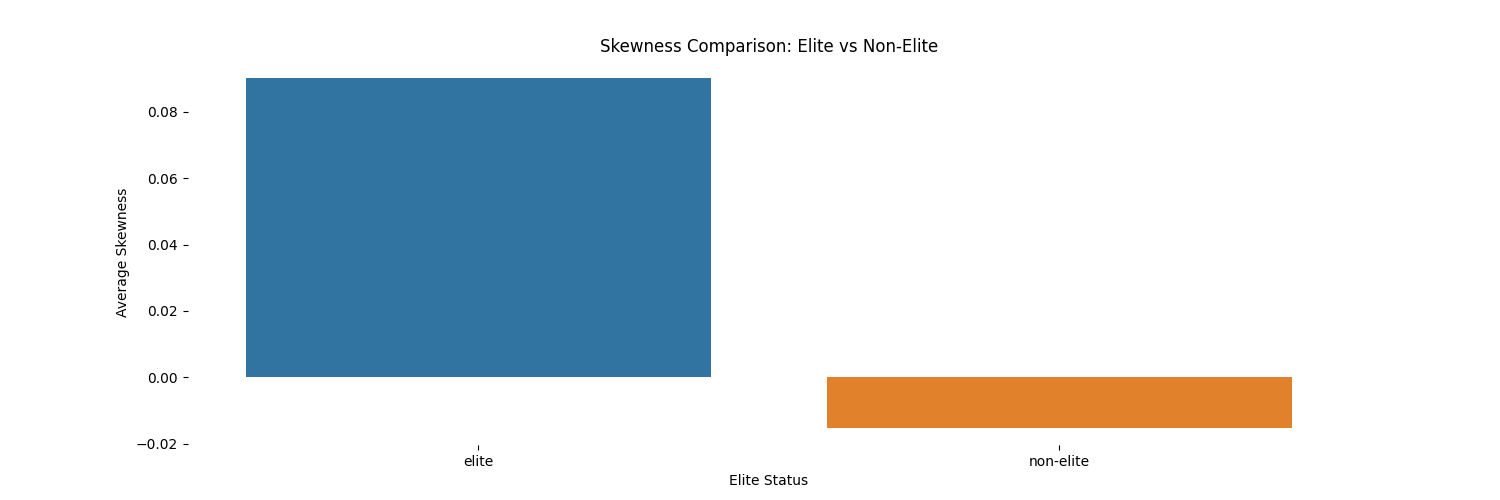

In [42]:
%matplot plt

The above bar chart shows the average skewness for both Elite and Non-Elite reviews. Suprisingly the highest skewness came from the Elite reviewers. It seems that Elite ratings were skewed to be more positive, while non-elites skewed to be more negative. However, there is a much larger degree of skew amongst the Elite reviews. Also note,Elite user reviews represent a minority of all yelp ratings (about 15.63%), therefore the average skew displayed in this graph by elite users may be more affected by outliers, than the non-elite.

Nonetheless, the observation displayed by the above bar plot supports the conclusion that Elite yelpers aren't necessarily more trustworthy than Non-elite.